In [1]:
import pathlib
import dask
import dask.dataframe as dd
import psutil
import requests, re
import numpy as np
import pandas as pd

# dask - ideas: 

multiple CSV reads, parallelize, and write to single CSV

parallel operations, like histogramming

In [2]:
# print amount of available RAM memory
print(f"Available RAM: {psutil.virtual_memory().available / (1024 ** 3):.2f} GB")

Available RAM: 1.60 GB


In [3]:
# using pathlib create directory called meteo
data_dir = pathlib.Path("meteo")
data_dir.mkdir(exist_ok=True)


In [4]:
base = "https://meteo.gig.eu/archiwum/2025/"
dest = pathlib.Path("meteo")
dest.mkdir(exist_ok=True)
html = requests.get(base).text
files = re.findall(r'href="([^"]+\.\w+)"', html)
for f in files:
    url = f if f.startswith("http") else base + f
    name = pathlib.Path(url).name
    print("Downloading", name)
    with requests.get(url, stream=True) as r, open(dest/name, "wb") as out:
        for chunk in r.iter_content(1024*64):
            out.write(chunk)

In [5]:
first_file = next(data_dir.glob("*.txt"))
first_file

PosixPath('meteo/20250602.txt')

In [6]:
df = pd.read_csv(first_file,sep='\s+', skiprows=[1,2], na_values = ['---'])
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_183112/1277020432.py:1: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(first_file,sep='\s+', skiprows=[1,2], na_values = ['---'])


Temp  Hi  Low  Out  Dew  Wind  Wind.1 Wind.2  Hi.1  \
25-05-25 0:30 10.9 11.1  10.7  73  6.3  0.4    N   0.8     1.3      N  10.9   
         1:00 10.3 10.7   9.9  77  6.5  0.0    N   0.0     0.9      N  10.3   
         1:30 9.6  9.9    9.2  80  6.3  0.0  NaN   0.0     0.0    NaN   9.6   
         2:00 9.0  9.2    8.8  84  6.4  0.0    N   0.0     0.9      N   9.0   
         2:30 8.8  8.9    8.6  85  6.4  0.0  NaN   0.0     0.0    NaN   8.8   

                         Hi.2  ...  Heat.1  Cool  In  In.1  In.2  In.3  \
25-05-25 0:30 10.9 11.1  10.7  ...     0.0  21.9  34   5.3  20.5  0.00   
         1:00 10.3 10.7  10.2  ...     0.0  21.8  34   5.3  20.4  0.03   
         1:30 9.6  9.9    9.5  ...     0.0  21.7  34   5.2  20.2  0.00   
         2:00 9.0  9.2    9.0  ...     0.0  21.7  34   5.1  20.2  0.03   
         2:30 8.8  8.9    8.8  ...     0.0  21.6  34   5.1  20.1  0.00   

                         Wind.4  Wind.5    ISS  Arc.  
25-05-25 0:30 10.9 11.1     699       1  100.0    30  
         1:00 10.3 10.7     701       1  100.0    30  
         1:30 9.6  9.9      700       1  100.0    30  
         2:00 9.0  9.2      702       1  100.0    30  
         2:30 8.8  8.9      701       1  100.0    30  

[5 rows x 32 columns]

<Axes: xlabel='Temp', ylabel='Wind.1'>

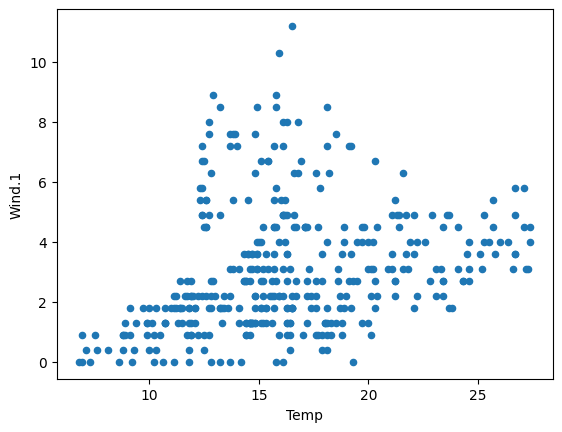

In [7]:
df.plot.scatter(x='Temp',y='Wind.1')

In [27]:
df_list = []
for file_path in data_dir.glob("*.txt"):
    df_tmp = pd.read_csv(file_path,sep='\s+', skiprows=[1,2], na_values = ['---', '------'])
    df_list.append(df_tmp)
df_all = pd.concat(df_list)
df_all

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_183112/3789781590.py:3: SyntaxWarning: invalid escape sequence '\s'
  df_tmp = pd.read_csv(file_path,sep='\s+', skiprows=[1,2], na_values = ['---', '------'])


Temp    Hi  Low  Out  Dew  Wind  Wind.1 Wind.2  \
25-05-25 0:30  10.9 11.1  10.7  73.0  6.3  0.4    N  0.80     1.3      N   
         1:00  10.3 10.7   9.9  77.0  6.5  0.0    N  0.00     0.9      N   
         1:30  9.6  9.9    9.2  80.0  6.3  0.0  NaN  0.00     0.0    NaN   
         2:00  9.0  9.2    8.8  84.0  6.4  0.0    N  0.00     0.9      N   
         2:30  8.8  8.9    8.6  85.0  6.4  0.0  NaN  0.00     0.0    NaN   
...                        ...   ...  ...  ...  ...   ...     ...    ...   
25-05-04 22:00 11.4 11.6  11.2  68.0  5.7  0.9    N  1.61     3.6      N   
         22:30 11.1 11.2  10.9  70.0  5.8  0.9    N  1.61     2.2      N   
         23:00 10.8 10.9  10.6  70.0  5.6  0.9    N  1.61     2.2      N   
         23:30 10.4 10.6  10.3  71.0  5.4  0.9    N  1.61     2.2      N   
25-05-05 00:00 10.2 10.3  10.1  71.0  5.1  0.9    N  1.61     1.8      N   

                          Hi.1  Hi.2  ...  Heat.1  Cool    In  In.1  In.2  \
25-05-25 0:30  10.9 11.1  10.9  10.7  ...     0.0  21.9  34.0   5.3  20.5   
         1:00  10.3 10.7  10.3  10.2  ...     0.0  21.8  34.0   5.3  20.4   
         1:30  9.6  9.9    9.6   9.5  ...     0.0  21.7  34.0   5.2  20.2   
         2:00  9.0  9.2    9.0   9.0  ...     0.0  21.7  34.0   5.1  20.2   
         2:30  8.8  8.9    8.8   8.8  ...     0.0  21.6  34.0   5.1  20.1   
...                        ...   ...  ...     ...   ...   ...   ...   ...   
25-05-04 22:00 11.4 11.6  11.4  10.9  ...     0.0  24.6  34.0   7.7  23.8   
         22:30 11.1 11.2  11.1  10.7  ...     0.0  24.5  34.0   7.6  23.7   
         23:00 10.8 10.9  10.8  10.4  ...     0.0  24.3  34.0   7.5  23.5   
         23:30 10.4 10.6  10.4  10.1  ...     0.0  24.2  34.0   7.4  23.4   
25-05-05 00:00 10.2 10.3  10.2   9.9  ...     0.0  24.2  34.0   7.4  23.4   

                          In.3  Wind.4  Wind.5    ISS  Arc.  
25-05-25 0:30  10.9 11.1  0.00     699       1  100.0    30  
         1:00  10.3 10.7  0.03     701       1  100.0    30  
         1:30  9.6  9.9   0.00     700       1  100.0    30  
         2:00  9.0  9.2   0.03     702       1  100.0    30  
         2:30  8.8  8.9   0.00     701       1  100.0    30  
...                        ...     ...     ...    ...   ...  
25-05-04 22:00 11.4 11.6  0.03     701       1  100.0    30  
         22:30 11.1 11.2  0.00     699       1  100.0    30  
         23:00 10.8 10.9  0.03     703       1  100.0    30  
         23:30 10.4 10.6  0.00     699       1  100.0    30  
25-05-05 00:00 10.2 10.3  0.03     701       1  100.0    30  

[14108 rows x 32 columns]

In [28]:
df_all.dtypes

Temp       float64
Hi         float64
Low        float64
Out        float64
Dew         object
Wind       float64
Wind.1     float64
Wind.2      object
Hi.1       float64
Hi.2       float64
Wind.3     float64
Heat       float64
THW        float64
THSW       float64
Rain       float64
Solar      float64
Solar.1    float64
Hi.3       float64
Solar.2    float64
UV         float64
UV.1       float64
Hi.4       float64
Heat.1     float64
Cool       float64
In         float64
In.1       float64
In.2       float64
In.3       float64
Wind.4       int64
Wind.5       int64
ISS        float64
Arc.         int64
dtype: object

<Axes: xlabel='Temp', ylabel='Wind.1'>

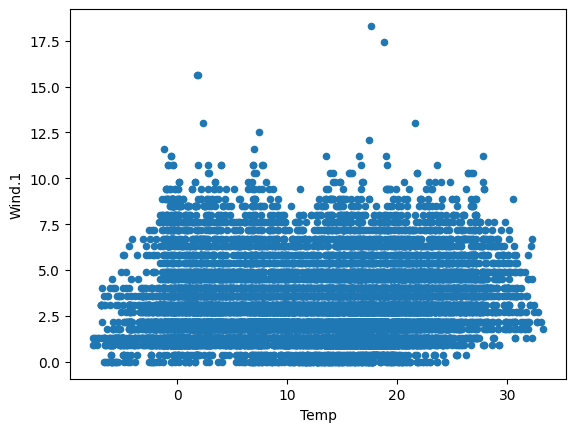

In [29]:
df_all.plot.scatter(x='Temp',y='Wind.1')

In [30]:
# read all files using dask
df_dask = dask.dataframe.read_csv(data_dir/"*.txt", sep='\s+', skiprows=[1,2], na_values = ['---', '------'], assume_missing=True)
df_dask.head()

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_183112/135500995.py:2: SyntaxWarning: invalid escape sequence '\s'
  df_dask = dask.dataframe.read_csv(data_dir/"*.txt", sep='\s+', skiprows=[1,2], na_values = ['---', '------'], assume_missing=True)


Temp    Hi  Low  Out Dew  Wind  Wind.1 Wind.2  Hi.1  \
24-12-29 0:30  0.4  0.4   0.3  98.0  0.1  0.0  NE   0.0     0.9     NE   0.4   
         1:00  0.1  0.3  -0.1  98.0 -0.2  0.0  NE   0.0     0.4     NE   0.1   
         1:30 -0.2 -0.1  -0.3  98.0 -0.5  0.0  NE   0.0     0.9     NE  -0.2   
         2:00 -0.3 -0.3  -0.4  98.0 -0.6  0.0  NE   0.0     0.9     NE  -0.3   
         2:30 -0.5 -0.4  -0.6  98.0 -0.8  0.0  NE   0.0     0.9     NE  -0.5   

                         Hi.2  ...  Heat.1  Cool    In  In.1  In.2  In.3  \
24-12-29 0:30  0.4  0.4   0.4  ...     0.0  18.4  30.0   0.5  16.4   0.0   
         1:00  0.1  0.3   0.1  ...     0.0  18.4  30.0   0.5  16.4   0.0   
         1:30 -0.2 -0.1  -0.2  ...     0.0  18.3  30.0   0.4  16.4   0.0   
         2:00 -0.3 -0.3  -0.3  ...     0.0  18.3  30.0   0.4  16.3   0.0   
         2:30 -0.5 -0.4  -0.5  ...     0.0  18.3  30.0   0.4  16.3   0.0   

                         Wind.4  Wind.5    ISS  Arc.  
24-12-29 0:30  0.4  0.4   699.0     1.0  100.0  30.0  
         1:00  0.1  0.3   699.0     1.0  100.0  30.0  
         1:30 -0.2 -0.1   699.0     1.0  100.0  30.0  
         2:00 -0.3 -0.3   700.0     1.0  100.0  30.0  
         2:30 -0.5 -0.4   701.0     1.0  100.0  30.0  

[5 rows x 32 columns]

In [31]:
df_dask.dtypes

Temp               float64
Hi                 float64
Low                float64
Out                float64
Dew        string[pyarrow]
Wind               float64
Wind.1             float64
Wind.2     string[pyarrow]
Hi.1               float64
Hi.2               float64
Wind.3             float64
Heat               float64
THW                float64
THSW               float64
Rain               float64
Solar              float64
Solar.1            float64
Hi.3               float64
Solar.2            float64
UV                 float64
UV.1               float64
Hi.4               float64
Heat.1             float64
Cool               float64
In                 float64
In.1               float64
In.2               float64
In.3               float64
Wind.4             float64
Wind.5             float64
ISS                float64
Arc.               float64
dtype: object

<Axes: xlabel='Temp', ylabel='Wind.1'>

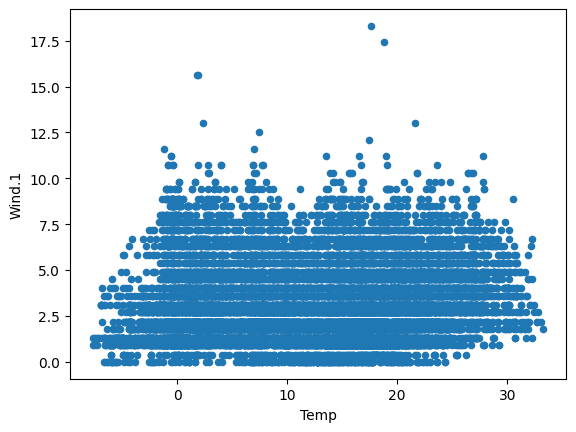

In [32]:
df_dask.compute().plot.scatter(x='Temp',y='Wind.1')